<a href="https://colab.research.google.com/github/jrebull/AnaliticaPrescriptiva/blob/main/Ejercicios_de_Programacion_Lineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GitHub Link of this notebook:

### https://github.com/jrebull/AnaliticaPrescriptiva/blob/main/Ejercicios_de_Programacion_Lineal.ipynb

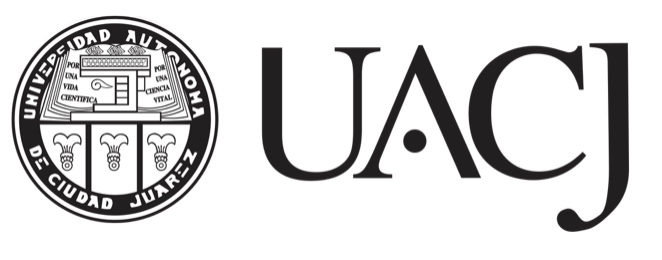

# **UNIVERSIDAD AUTÓNOMA DE CIUDAD JUÁREZ**

## **Maestría en Inteligencia Artificial y Analítica de Datos (MIAAD)**

---

# **Ejercicios de Programación Lineal**
### **Semana 02**

---

**Profesor titular:** Dr. Gilberto Rivera Zárate  
**Alumno:** Javier Augusto Rebull Saucedo  
**Matrícula:** 263483  

**Asignatura:** Programación para Analítica Prescriptiva y de Apoyo a la Decisión  
**Fecha:** 23 de agosto de 2025


---
---

# ✨ Introducción — Programación Lineal

La **programación lineal (PL)** es una técnica de optimización que busca **maximizar o minimizar** una función objetivo **lineal** sujeta a **restricciones lineales**. Sirve para decidir la **mejor asignación de recursos escasos** (capacidad, presupuesto, tiempo, insumos) en problemas reales de producción, logística, mezclas, dietas e inversión. Su poder radica en la claridad: la región factible es un **poliedro** y, cuando existe, el óptimo se alcanza en un **vértice**, lo que permite resolver con métodos eficientes (como **simplex** o **puntos interiores**) y obtener resultados **interpretables** y **auditables**.

En este notebook traduciremos enunciados a **modelos de PL** (parámetros, **variables de decisión**, **función objetivo**, **restricciones**), los **implementaremos en Pyomo**, los **resolveremos** con un *solver* disponible y **verificaremos** la solución (factibilidad, uso de recursos, restricciones activas). Cerraremos con una **interpretación en contexto** y pequeñas pruebas de **escenarios “qué pasaría si…”** para observar cómo se mueven las decisiones óptimas al cambiar los parámetros.


---
---

# Instalacion de Requisitos

In [1]:
# instala el ejecutable del solver del sistema
!apt-get -y install -qq glpk-utils

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

In [2]:
!apt-get -qq update
!apt-get -y -qq install glpk-utils

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


# Declaración de Librerias

In [3]:
# Pyomo: optimización
import pyomo.environ as pyo

# Tablas en consola
from tabulate import tabulate

# 📘 Problema 1 — Ápex Televisión

## 📝 Descripción del problema
La empresa **Ápex Televisión** debe decidir cuántos televisores de **27″** y **20″** producir en una de sus fábricas.  
Un estudio de mercado proyecta ventas **a lo más** de **40** televisores de 27″ y **10** de 20″.  
La planta dispone de **500 horas-hombre** al mes. Producir un televisor de **27″** requiere **20 h**, y uno de **20″** requiere **10 h**.  
Cada televisor de **27″** deja una ganancia de **\$120** y cada televisor de **20″** deja **\$80**.  
Un distribuidor se compromete a comprar **todo lo producido** mientras **no exceda** los máximos del estudio.

---

## 📊 Datos clave

| Concepto                  | 27″            | 20″           |
|---------------------------|----------------|---------------|
| Límite de mercado (unid.) | ≤ 40           | ≤ 10          |
| Horas-hombre por unidad   | 20 h           | 10 h          |
| Ganancia por unidad       | \$120          | \$80          |

**Horas-hombre disponibles al mes:** **500 h**

---

**Pregunta:** ¿Cuántas unidades de cada tamaño debe producir Ápex Televisión para **maximizar** sus ganancias?


# 🧩 Solución

## 📐 Modelo matemático (PL)

**Variables de decisión**
- **X₁**: televisores de **27″** a producir  
- **X₂**: televisores de **20″** a producir

**Función objetivo (ZMax)**

$$
\mathrm{ZMax} \;=\; 120\,X_{1} \;+\; 80\,X_{2}
$$

**Sujeto a restricciones**

$$
\begin{aligned}
X_{1} &\le 40 &\quad& \text{(Límite de mercado 27″)}\\
X_{2} &\le 10 &\quad& \text{(Límite de mercado 20″)}\\
20\,X_{1} + 10\,X_{2} &\le 500 &\quad& \text{(Horas-hombre)}\\
X_{1},\,X_{2} &\ge 0 &\quad& \text{(No negatividad)}
\end{aligned}
$$

> La solución numérica se calculará con **Pyomo** en la siguiente celda.


# Codigo de Solución en Pyomo

In [4]:
# --------------------------------
# 1) Modelo de optimización
# --------------------------------
model = pyo.ConcreteModel()

# --------------------------------
# 2) Variables de decisión
#    X1: TVs 27"
#    X2: TVs 20"
# --------------------------------
model.X1 = pyo.Var(within=pyo.NonNegativeReals)
model.X2 = pyo.Var(within=pyo.NonNegativeReals)

# --------------------------------
# 3) Función objetivo (ZMax)
#    ZMax = 120*X1 + 80*X2
# --------------------------------
model.obj = pyo.Objective(
    expr=120*model.X1 + 80*model.X2,
    sense=pyo.maximize
)

# --------------------------------
# 4) Restricciones
#    (a) Mercado 27": X1 ≤ 40
#    (b) Mercado 20": X2 ≤ 10
#    (c) Horas: 20*X1 + 10*X2 ≤ 500
# --------------------------------
model.market27 = pyo.Constraint(expr=model.X1 <= 40)
model.market20 = pyo.Constraint(expr=model.X2 <= 10)
model.labor    = pyo.Constraint(expr=20*model.X1 + 10*model.X2 <= 500)

# --------------------------------
# 5) Resolver
# --------------------------------
solver = pyo.SolverFactory('glpk')
result = solver.solve(model)

# --------------------------------
# 6) Resultados
# --------------------------------
x1 = pyo.value(model.X1)
x2 = pyo.value(model.X2)
zmax = pyo.value(model.obj)
hours_used = 20*x1 + 10*x2

tabla_decisiones = [
    ["27″ (X₁)", x1],
    ["20″ (X₂)", x2],
]

tabla_verificacion = [
    ["Mercado 27″ (≤ 40)", 40, x1, "OK" if x1 <= 40 + 1e-6 else "VIOLA"],
    ["Mercado 20″ (≤ 10)", 10, x2, "OK" if x2 <= 10 + 1e-6 else "VIOLA"],
    ["Horas (≤ 500)", 500, hours_used, "OK" if hours_used <= 500 + 1e-6 else "VIOLA"],
]

print("\n" + "="*42)
print("   📺 RESULTADOS — Ápex Televisión")
print("="*42)
print(tabulate(tabla_decisiones, headers=["Decisión", "Cantidad"], tablefmt="fancy_grid", floatfmt=".2f"))

print("\n🔎 Verificación")
print(tabulate(tabla_verificacion, headers=["Restricción", "Límite", "Valor", "Estado"], tablefmt="fancy_grid", floatfmt=".2f"))

print(f"\n💰 Ganancia máxima (ZMax): ${zmax:,.2f}")
print("="*42)



   📺 RESULTADOS — Ápex Televisión
╒════════════╤════════════╕
│ Decisión   │   Cantidad │
╞════════════╪════════════╡
│ 27″ (X₁)   │      20.00 │
├────────────┼────────────┤
│ 20″ (X₂)   │      10.00 │
╘════════════╧════════════╛

🔎 Verificación
╒════════════════════╤══════════╤═════════╤══════════╕
│ Restricción        │   Límite │   Valor │ Estado   │
╞════════════════════╪══════════╪═════════╪══════════╡
│ Mercado 27″ (≤ 40) │       40 │   20.00 │ OK       │
├────────────────────┼──────────┼─────────┼──────────┤
│ Mercado 20″ (≤ 10) │       10 │   10.00 │ OK       │
├────────────────────┼──────────┼─────────┼──────────┤
│ Horas (≤ 500)      │      500 │  500.00 │ OK       │
╘════════════════════╧══════════╧═════════╧══════════╛

💰 Ganancia máxima (ZMax): $3,200.00


## ✅ Conclusiones

- **Plan óptimo:** producir **X₁ = 20** (27″) y **X₂ = 10** (20″) con **ZMax = \$3,200**.
- **Restricciones activas (cuellos de botella):**  
  **Horas** (500 usadas) y **mercado de 20″** (tope 10).  
  La restricción de **mercado de 27″** queda con **holgura** (40 máx., se producen 20).
- **Intuición económica:** el 20″ rinde **\$8/h** (80/10) y el 27″ **\$6/h** (120/20); por eso conviene **saturar 20″** y usar las horas restantes en 27″.
- **Qué cambiaría el óptimo:**  
  Aumentar el **límite de mercado de 20″** o las **horas disponibles** elevaría la ganancia y movería la producción hacia más 20″ (mientras no se agoten las horas).
- **Robustez:** con los límites actuales, el modelo usa eficientemente los recursos y respeta la demanda máxima; cualquier mejora requiere **más horas** o **más demanda de 20″**.


---
---

# 📘 Problema 2 — Word Light

## 📝 Descripción del problema
La empresa **Word Light** fabrica dos dispositivos para lámparas (**producto 1** y **producto 2**) que consumen **partes de metal** y **componentes eléctricos**. La administración desea decidir cuántas unidades de cada producto fabricar para **maximizar la ganancia**, respetando la disponibilidad de recursos y una política comercial sobre el producto 2.

---

## 📊 Datos del problema

| Recurso / Métrica          | Producto 1 | Producto 2 |
|---------------------------|-----------:|-----------:|
| Partes de metal (u/unid.) | 1          | 3          |
| Componentes eléctricos (u/unid.) | 2    | 2          |

**Disponibilidades totales:**  
- Partes de metal: **200** unidades  
- Componentes eléctricos: **300** unidades

**Ganancias por unidad:**  
- **Producto 1:** **\$1** por unidad  
- **Producto 2:** **\$2** por unidad **solo para las primeras 60** unidades

**Regla de negocio (producto 2):** producir **más de 60** unidades **no está permitido** (no genera ganancia adicional y queda fuera de consideración).

---

**Pregunta:** ¿Cuántas unidades de **producto 1** y **producto 2** se deben fabricar para **maximizar** la ganancia total?


# 🧩 Solución

## 📐 Modelo matemático (PL)

**Variables de decisión**
- **X₁**: unidades a fabricar del **Producto 1**  
- **X₂**: unidades a fabricar del **Producto 2**

**Función objetivo (ZMax)**

$$
\mathrm{ZMax} \;=\; 1\,X_{1} \;+\; 2\,X_{2}
$$

**Sujeto a restricciones**

$$
\begin{aligned}
X_{1} + 3X_{2} &\le 200 && \text{(Partes de metal)}\\
2X_{1} + 2X_{2} &\le 300 && \text{(Componentes eléctricos)}\\
X_{2} &\le 60 && \text{(Tope comercial Producto 2)}\\
X_{1},\,X_{2} &\ge 0 && \text{(No negatividad)}
\end{aligned}
$$

> La solución numérica se calculará con **Pyomo** en la siguiente celda.


# Codigo de Solución en Pyomo

In [5]:
# --------------------------------
# 1) Modelo de optimización
# --------------------------------
model = pyo.ConcreteModel()

# --------------------------------
# 2) Variables de decisión
#    X1: unidades del Producto 1
#    X2: unidades del Producto 2
# --------------------------------
model.X1 = pyo.Var(within=pyo.NonNegativeReals)
model.X2 = pyo.Var(within=pyo.NonNegativeReals)

# --------------------------------
# 3) Función objetivo (ZMax)
#    ZMax = 1*X1 + 2*X2
# --------------------------------
model.obj = pyo.Objective(
    expr=1*model.X1 + 2*model.X2,
    sense=pyo.maximize
)

# --------------------------------
# 4) Restricciones
#    (a) Partes de metal: X1 + 3*X2 ≤ 200
#    (b) Componentes eléctricos: 2*X1 + 2*X2 ≤ 300
#    (c) Tope comercial P2: X2 ≤ 60
# --------------------------------
model.metal = pyo.Constraint(expr=model.X1 + 3*model.X2 <= 200)
model.elec  = pyo.Constraint(expr=2*model.X1 + 2*model.X2 <= 300)
model.capP2 = pyo.Constraint(expr=model.X2 <= 60)

# --------------------------------
# 5) Resolver
# --------------------------------
solver = pyo.SolverFactory('glpk')
result = solver.solve(model)

# --------------------------------
# 6) Resultados
# --------------------------------
x1 = pyo.value(model.X1)
x2 = pyo.value(model.X2)
zmax = pyo.value(model.obj)

metal_used = x1 + 3*x2
elec_used  = 2*x1 + 2*x2

tabla_decisiones = [
    ["Producto 1 (X₁)", x1],
    ["Producto 2 (X₂)", x2],
]

tabla_verificacion = [
    ["Partes de metal (≤ 200)", 200, metal_used, "OK" if metal_used <= 200 + 1e-6 else "VIOLA"],
    ["Componentes eléctricos (≤ 300)", 300, elec_used, "OK" if elec_used <= 300 + 1e-6 else "VIOLA"],
    ["Tope comercial P2 (X₂ ≤ 60)", 60, x2, "OK" if x2 <= 60 + 1e-6 else "VIOLA"],
]

print("\n" + "="*46)
print("   💡 RESULTADOS — Word Light (Problema 2)")
print("="*46)
print(tabulate(tabla_decisiones, headers=["Decisión", "Cantidad"], tablefmt="fancy_grid", floatfmt=".2f"))

print("\n🔎 Verificación")
print(tabulate(tabla_verificacion, headers=["Restricción", "Límite", "Valor", "Estado"], tablefmt="fancy_grid", floatfmt=".2f"))

print(f"\n💰 Ganancia máxima (ZMax): ${zmax:,.2f}")
print("="*46)



   💡 RESULTADOS — Word Light (Problema 2)
╒═════════════════╤════════════╕
│ Decisión        │   Cantidad │
╞═════════════════╪════════════╡
│ Producto 1 (X₁) │     125.00 │
├─────────────────┼────────────┤
│ Producto 2 (X₂) │      25.00 │
╘═════════════════╧════════════╛

🔎 Verificación
╒════════════════════════════════╤══════════╤═════════╤══════════╕
│ Restricción                    │   Límite │   Valor │ Estado   │
╞════════════════════════════════╪══════════╪═════════╪══════════╡
│ Partes de metal (≤ 200)        │      200 │  200.00 │ OK       │
├────────────────────────────────┼──────────┼─────────┼──────────┤
│ Componentes eléctricos (≤ 300) │      300 │  300.00 │ OK       │
├────────────────────────────────┼──────────┼─────────┼──────────┤
│ Tope comercial P2 (X₂ ≤ 60)    │       60 │   25.00 │ OK       │
╘════════════════════════════════╧══════════╧═════════╧══════════╛

💰 Ganancia máxima (ZMax): $175.00


## ✅ Conclusiones

- **Plan óptimo:** **X₁ = 125**, **X₂ = 25** → **ZMax = \$175.00**.
- **Restricciones activas (cuellos de botella):**  
  - **Partes de metal:** usado **200/200** ✅  
  - **Componentes eléctricos:** usado **300/300** ✅  
  - **Tope del Producto 2:** **inactivo** (X₂ = 25 < 60) → hay **holgura** de 35.
- **Intuición del mix:** el **Producto 2** aporta más ganancia por unidad de componentes eléctricos, pero consume **3** unidades de metal por pieza; el óptimo usa **algo de P2** hasta que el **metal** se vuelve limitante y completa con **P1** para aprovechar la **electricidad** restante.
- **La mezcla vence a los extremos:**  
  - Solo **P1** (por recursos): X₁ = 150 → **\$150**  
  - Solo **P2** (por tope): X₂ = 60 → **\$120**  
  - **Mezcla óptima:** **\$175** ✅
- **Qué movería el óptimo:** aumentar **metal** o **componentes eléctricos** elevaría la ganancia; **relajar el tope de P2** por sí solo **no cambia** la solución mientras los recursos sigan saturados.


---
---

# 📘 Problema 3 — Primo Seguros

## 📝 Descripción del problema
La compañía **Primo Seguros** planea introducir dos nuevas líneas: **Seguro de riesgo especial** y **Hipotecas**.  
La ganancia esperada por unidad es de **\$5** para el seguro de riesgo especial y **\$2** para hipotecas.  
La administración desea fijar las **cuotas de venta** de ambas líneas para **maximizar la ganancia total**, respetando la disponibilidad de horas-hombre en sus departamentos.

### Recursos y requerimientos por unidad

| Departamento     | Seguro de riesgo especial (h/u) | Hipotecas (h/u) | Horas-hombre disponibles |
|------------------|--------------------------------:|----------------:|-------------------------:|
| Suscripciones    | 3                                | 2               | 2400                     |
| Administración   | 0                                | 1               | 800                      |
| Reclamaciones    | 2                                | 0               | 1200                     |

**Objetivo:** determinar las cuotas de venta de cada línea para **maximizar la ganancia** sin exceder las **horas-hombre disponibles** en cada departamento.


# 🧩 Solución

## 📐 Modelo matemático (PL)

**Variables de decisión**
- **X₁**: unidades/cuotas de **Seguro de riesgo especial**  
- **X₂**: unidades/cuotas de **Hipotecas**

**Función objetivo (ZMax)**
$$
\mathrm{ZMax} \;=\; 5\,X_{1} \;+\; 2\,X_{2}
$$

**Sujeto a restricciones (horas-hombre por departamento)**
$$
\begin{aligned}
3X_{1} + 2X_{2} &\le 2400 && \text{(Suscripciones)}\\[2pt]
X_{2} &\le 800 && \text{(Administración)}\\[2pt]
X_{1} &\le 600 && \text{(Reclamaciones)}\\[2pt]
X_{1},\,X_{2} &\ge 0 && \text{(No negatividad)}
\end{aligned}
$$

> La solución numérica se calculará con **Pyomo** en la siguiente celda.


# Codigo de Solución en Pyomo

In [6]:
# --------------------------------
# 1) Modelo de optimización
# --------------------------------
model = pyo.ConcreteModel()

# --------------------------------
# 2) Variables de decisión
#    X1: cuotas/unidades de Seguro de riesgo especial
#    X2: cuotas/unidades de Hipotecas
# --------------------------------
model.X1 = pyo.Var(within=pyo.NonNegativeReals)
model.X2 = pyo.Var(within=pyo.NonNegativeReals)

# --------------------------------
# 3) Función objetivo (ZMax)
#    ZMax = 5*X1 + 2*X2
# --------------------------------
model.obj = pyo.Objective(
    expr=5*model.X1 + 2*model.X2,
    sense=pyo.maximize
)

# --------------------------------
# 4) Restricciones (horas-hombre)
#    (a) Suscripciones: 3*X1 + 2*X2 ≤ 2400
#    (b) Administración: X2 ≤ 800
#    (c) Reclamaciones:  X1 ≤ 600
# --------------------------------
model.subs = pyo.Constraint(expr=3*model.X1 + 2*model.X2 <= 2400)
model.admin = pyo.Constraint(expr=model.X2 <= 800)
model.recl  = pyo.Constraint(expr=model.X1 <= 600)

# --------------------------------
# 5) Resolver
# --------------------------------
solver = pyo.SolverFactory('glpk')
result = solver.solve(model)

# --------------------------------
# 6) Resultados
# --------------------------------
x1 = pyo.value(model.X1)
x2 = pyo.value(model.X2)
zmax = pyo.value(model.obj)

subs_used  = 3*x1 + 2*x2
admin_used = x2
recl_used  = x1

tabla_decisiones = [
    ["Seguro riesgo especial (X₁)", x1],
    ["Hipotecas (X₂)", x2],
]

tabla_verificacion = [
    ["Suscripciones (≤ 2400 h)", 2400, subs_used, "OK" if subs_used <= 2400 + 1e-6 else "VIOLA"],
    ["Administración (X₂ ≤ 800)", 800, admin_used, "OK" if admin_used <= 800 + 1e-6 else "VIOLA"],
    ["Reclamaciones (X₁ ≤ 600)", 600, recl_used, "OK" if recl_used <= 600 + 1e-6 else "VIOLA"],
]

print("\n" + "="*54)
print("   🏢 RESULTADOS — Primo Seguros (Problema 3)")
print("="*54)
print(tabulate(tabla_decisiones, headers=["Decisión", "Cantidad"], tablefmt="fancy_grid", floatfmt=".2f"))

print("\n🔎 Verificación")
print(tabulate(tabla_verificacion, headers=["Restricción", "Límite", "Valor", "Estado"], tablefmt="fancy_grid", floatfmt=".2f"))

print(f"\n💰 Ganancia máxima (ZMax): ${zmax:,.2f}")
print("="*54)



   🏢 RESULTADOS — Primo Seguros (Problema 3)
╒═════════════════════════════╤════════════╕
│ Decisión                    │   Cantidad │
╞═════════════════════════════╪════════════╡
│ Seguro riesgo especial (X₁) │     600.00 │
├─────────────────────────────┼────────────┤
│ Hipotecas (X₂)              │     300.00 │
╘═════════════════════════════╧════════════╛

🔎 Verificación
╒═══════════════════════════╤══════════╤═════════╤══════════╕
│ Restricción               │   Límite │   Valor │ Estado   │
╞═══════════════════════════╪══════════╪═════════╪══════════╡
│ Suscripciones (≤ 2400 h)  │     2400 │ 2400.00 │ OK       │
├───────────────────────────┼──────────┼─────────┼──────────┤
│ Administración (X₂ ≤ 800) │      800 │  300.00 │ OK       │
├───────────────────────────┼──────────┼─────────┼──────────┤
│ Reclamaciones (X₁ ≤ 600)  │      600 │  600.00 │ OK       │
╘═══════════════════════════╧══════════╧═════════╧══════════╛

💰 Ganancia máxima (ZMax): $3,600.00


## ✅ Conclusiones

- **Plan óptimo:** **X₁ = 600** (seguro de riesgo especial) y **X₂ = 300** (hipotecas) con **ZMax = \$3,600.00**.
- **Restricciones activas (cuellos de botella):**
  - **Suscripciones:** usado **2400/2400** h ✅
  - **Reclamaciones:** usado **600/600** h ✅
  - **Administración:** **300/800** h → **holgura** de 500 h (no limita la solución).
- **Lectura operativa:** el producto X₁ es más rentable por unidad ( \$5 vs \$2 ) pero consume horas de **Reclamaciones** además de **Suscripciones**; al agotarse ambos recursos, el modelo fija **X₁ en 600** y usa **Suscripciones restantes** junto con **Administración** para producir **X₂ = 300**.
- **Mezcla vs. extremos:**
  - Solo **X₁** (por recursos): hasta **600** → **\$3,000**.
  - Solo **X₂** (por recursos): hasta **800** → **\$1,600**.
  - **Mezcla óptima:** **\$3,600** → supera a cualquier extremo.
- **Sensibilidad práctica:** aumentar horas en **Suscripciones** o **Reclamaciones** podría **elevar la ganancia**. Incrementar solo **Administración** no cambia el óptimo actual (no es restrictiva).


---
---

# 📘 Problema 4 — Weenis & Buns

## 📝 Descripción del problema
La planta **Weenis & Buns** produce dos artículos para hotdogs: **salchichas** y **panes**.  
Dispone de recursos limitados:

- **Harina molida internamente:** hasta **200 lb/semana**. Cada **pan** usa **0.1 lb** de harina.  
- **Producto de puerco recibido:** **800 lb/semana** (contrato con Pigland Inc.). Cada **salchicha** usa **0.25 lb** de puerco.  
- **Mano de obra:** **5** empleados de tiempo completo (**40 h/semana** cada uno) ⇒ **200 h/semana = 12,000 min**.  
  - Cada **salchicha** requiere **3 min** de mano de obra.  
  - Cada **pan** requiere **2 min** de mano de obra.  
- El resto de ingredientes está disponible en cantidad suficiente.

**Ganancias por unidad:** salchicha **\$0.20**; pan **\$0.10**.

---

## 📊 Datos clave

| Recurso / Consumo por unidad | Salchicha | Pan |
|---|---:|---:|
| Harina (lb/unid.) | 0.00 | 0.10 |
| Producto de puerco (lb/unid.) | 0.25 | 0.00 |
| Mano de obra (min/unid.) | 3 | 2 |

**Disponibilidades semanales:** Harina **≤ 200 lb**, Puerco **≤ 800 lb**, Mano de obra **≤ 12,000 min**.

---

**Objetivo:** determinar cuántas **salchichas** y cuántos **panes** producir por semana para **maximizar la ganancia** total sin exceder las capacidades de harina, puerco y mano de obra.


# 🧩 Solución

## 📐 Modelo matemático (PL)

**Variables de decisión**
- **X₁**: número de **salchichas** a producir por semana  
- **X₂**: número de **panes** a producir por semana

**Función objetivo (ZMax)**

$$
\mathrm{ZMax} \;=\; 0.20\,X_{1} \;+\; 0.10\,X_{2}
$$

**Sujeto a restricciones**

$$
\begin{aligned}
\text{(Harina)}\quad & 0.10\,X_{2} \le 200 &&\Rightarrow\; X_{2} \le 2000\\[2pt]
\text{(Producto de puerco)}\quad & 0.25\,X_{1} \le 800 &&\Rightarrow\; X_{1} \le 3200\\[2pt]
\text{(Mano de obra)}\quad & 3\,X_{1} + 2\,X_{2} \le 12{,}000\\[2pt]
\text{(No negatividad)}\quad & X_{1},\,X_{2} \ge 0
\end{aligned}
$$

> La solución numérica se calculará con **Pyomo** en la siguiente celda.


# Codigo de Solución en Pyomo

In [7]:
# --------------------------------
# 1) Modelo de optimización
# --------------------------------
model = pyo.ConcreteModel()

# --------------------------------
# 2) Variables de decisión
#    X1: salchichas/semana
#    X2: panes/semana
# --------------------------------
model.X1 = pyo.Var(within=pyo.NonNegativeReals)
model.X2 = pyo.Var(within=pyo.NonNegativeReals)

# --------------------------------
# 3) Función objetivo (ZMax)
#    ZMax = 0.20*X1 + 0.10*X2
# --------------------------------
model.obj = pyo.Objective(
    expr=0.20*model.X1 + 0.10*model.X2,
    sense=pyo.maximize
)

# --------------------------------
# 4) Restricciones
#    (a) Harina: 0.10*X2 ≤ 200  → X2 ≤ 2000
#    (b) Puerco: 0.25*X1 ≤ 800  → X1 ≤ 3200
#    (c) Mano de obra (min): 3*X1 + 2*X2 ≤ 12000
# --------------------------------
model.flour = pyo.Constraint(expr=model.X2 <= 2000)                # 0.10 lb/u, 200 lb totales
model.pork  = pyo.Constraint(expr=model.X1 <= 3200)                # 0.25 lb/u, 800 lb totales
model.labor = pyo.Constraint(expr=3*model.X1 + 2*model.X2 <= 12000)# 5*40 h = 200 h = 12000 min

# --------------------------------
# 5) Resolver
# --------------------------------
solver = pyo.SolverFactory('glpk')
result = solver.solve(model)

# --------------------------------
# 6) Resultados
# --------------------------------
x1 = pyo.value(model.X1)
x2 = pyo.value(model.X2)
zmax = pyo.value(model.obj)

flour_used = 0.10*x2
pork_used  = 0.25*x1
labor_used = 3*x1 + 2*x2

tabla_decisiones = [
    ["Salchichas (X₁)", x1],
    ["Panes (X₂)", x2],
]

tabla_verificacion = [
    ["Harina (≤ 200 lb)", 200, flour_used, "OK" if flour_used <= 200 + 1e-6 else "VIOLA"],
    ["Puerco (≤ 800 lb)", 800, pork_used,  "OK" if pork_used  <= 800 + 1e-6 else "VIOLA"],
    ["Mano de obra (≤ 12000 min)", 12000, labor_used, "OK" if labor_used <= 12000 + 1e-6 else "VIOLA"],
]

print("\n" + "="*52)
print("   🌭 RESULTADOS — Weenis & Buns (Problema 4)")
print("="*52)
print(tabulate(tabla_decisiones, headers=["Decisión", "Cantidad"], tablefmt="fancy_grid", floatfmt=".2f"))

print("\n🔎 Verificación")
print(tabulate(tabla_verificacion, headers=["Restricción", "Límite", "Valor usado", "Estado"], tablefmt="fancy_grid", floatfmt=".2f"))

print(f"\n💰 Ganancia máxima (ZMax): ${zmax:,.2f}")
print("="*52)



   🌭 RESULTADOS — Weenis & Buns (Problema 4)
╒═════════════════╤════════════╕
│ Decisión        │   Cantidad │
╞═════════════════╪════════════╡
│ Salchichas (X₁) │    3200.00 │
├─────────────────┼────────────┤
│ Panes (X₂)      │    1200.00 │
╘═════════════════╧════════════╛

🔎 Verificación
╒════════════════════════════╤══════════╤═══════════════╤══════════╕
│ Restricción                │   Límite │   Valor usado │ Estado   │
╞════════════════════════════╪══════════╪═══════════════╪══════════╡
│ Harina (≤ 200 lb)          │      200 │        120.00 │ OK       │
├────────────────────────────┼──────────┼───────────────┼──────────┤
│ Puerco (≤ 800 lb)          │      800 │        800.00 │ OK       │
├────────────────────────────┼──────────┼───────────────┼──────────┤
│ Mano de obra (≤ 12000 min) │    12000 │      12000.00 │ OK       │
╘════════════════════════════╧══════════╧═══════════════╧══════════╛

💰 Ganancia máxima (ZMax): $760.00


## ✅ Conclusiones

- **Plan óptimo:** X₁ = **3,200** salchichas y X₂ = **1,200** panes → **ZMax = \$760.00**.

- **Restricciones activas (cuellos de botella):**
  - Puerco: **800/800 lb** ✅
  - Mano de obra: **12,000/12,000 min** ✅
  - Harina: **120/200 lb** → **holgura de 80 lb** (no limita)

- **Intuición económica:** la salchicha rinde ≈ **0.0667 \$/min** (0.20/3) y el pan **0.05 \$/min** (0.10/2).  
  Por eso el modelo **satura** mano de obra y puerco con más salchichas y usa la harina disponible para completar con panes.

- **Mezcla vs. extremos:**
  - Solo salchichas (limitado por puerco): 3,200 → **\$640.00**
  - Solo panes (limitado por harina): 2,000 → **\$200.00**
  - **Mezcla óptima:** **\$760.00** ✅

- **Sensibilidad práctica:** aumentar **puerco** o **minutos de mano de obra** puede elevar la ganancia; aumentar solo **harina** no cambia el óptimo actual.


---
---

# 📘 Problema 5 — Omega Manufactura

## 📝 Descripción del problema
La empresa **Omega** descontinuó una línea no rentable y ahora dispone de **capacidad ociosa** en su planta. La gerencia desea asignar esta capacidad a uno o más de **tres productos** (1, 2 y 3), respetando la **disponibilidad de horas–máquina por semana** en cada tipo de equipo.

### Capacidad disponible por máquina (horas/semana)

| Tipo de máquina | Capacidad |
|---|---:|
| Fresadora       | **550** |
| Torno           | **350** |
| Rectificadora   | **150** |

### Horas–máquina requeridas por unidad de producto

| Tipo de máquina | Producto 1 | Producto 2 | Producto 3 |
|---|---:|---:|---:|
| Fresadora       | 9 | 3 | 5 |
| Torno           | 5 | 4 | 0 |
| Rectificadora   | 3 | 0 | 2 |

### Ganancia unitaria
- Producto 1: **\$50** por unidad  
- Producto 2: **\$20** por unidad  
- Producto 3: **\$25** por unidad

**Objetivo:** determinar cuántas unidades producir de cada producto para **maximizar la ganancia**, sin exceder las capacidades de **fresadora**, **torno** y **rectificadora**.


# 🧩 Solución

## 📐 Modelo matemático (PL)

**Variables de decisión**
- **X₁**: unidades a producir del **Producto 1**  
- **X₂**: unidades a producir del **Producto 2**  
- **X₃**: unidades a producir del **Producto 3**

**Función objetivo (ZMax)**

$$
\mathrm{ZMax} \;=\; 50\,X_{1} \;+\; 20\,X_{2} \;+\; 25\,X_{3}
$$

**Sujeto a restricciones (horas–máquina por semana)**

$$
\begin{aligned}
9X_{1} + 3X_{2} + 5X_{3} &\le 500 && \text{(Fresadora)}\\[2pt]
5X_{1} + 4X_{2} \hspace{13pt} &\le 350 && \text{(Torno)}\\[2pt]
3X_{1} \hspace{28pt} + 2X_{3} &\le 150 && \text{(Rectificadora)}\\[2pt]
X_{1},\,X_{2},\,X_{3} &\ge 0 && \text{(No negatividad)}
\end{aligned}
$$

> La solución numérica se calculará con **Pyomo** en la siguiente celda.


# Codigo de Solución en Pyomo

In [9]:
# --------------------------------
# 1) Modelo de optimización
# --------------------------------
model = pyo.ConcreteModel()

# --------------------------------
# 2) Variables de decisión
#    X1: Producto 1
#    X2: Producto 2
#    X3: Producto 3
# --------------------------------
model.X1 = pyo.Var(within=pyo.NonNegativeReals)
model.X2 = pyo.Var(within=pyo.NonNegativeReals)
model.X3 = pyo.Var(within=pyo.NonNegativeReals)

# --------------------------------
# 3) Función objetivo (ZMax)
#    ZMax = 50*X1 + 20*X2 + 25*X3
# --------------------------------
model.obj = pyo.Objective(
    expr=50*model.X1 + 20*model.X2 + 25*model.X3,
    sense=pyo.maximize
)

# --------------------------------
# 4) Restricciones (horas–máquina/semana)
#    Fresadora: 9*X1 + 3*X2 + 5*X3 ≤ 500
#    Torno:     5*X1 + 4*X2        ≤ 350
#    Rectif.:   3*X1        + 2*X3 ≤ 150
# --------------------------------
model.fresadora = pyo.Constraint(expr=9*model.X1 + 3*model.X2 + 5*model.X3 <= 500)
model.torno     = pyo.Constraint(expr=5*model.X1 + 4*model.X2             <= 350)
model.rectif    = pyo.Constraint(expr=3*model.X1             + 2*model.X3 <= 150)

# --------------------------------
# 5) Resolver
# --------------------------------
solver = pyo.SolverFactory('glpk')
result = solver.solve(model)

# --------------------------------
# 6) Resultados
# --------------------------------
x1 = pyo.value(model.X1)
x2 = pyo.value(model.X2)
x3 = pyo.value(model.X3)
zmax = pyo.value(model.obj)

fresa_used = 9*x1 + 3*x2 + 5*x3
torno_used = 5*x1 + 4*x2
recti_used = 3*x1 + 2*x3

tabla_decisiones = [
    ["Producto 1 (X₁)", x1],
    ["Producto 2 (X₂)", x2],
    ["Producto 3 (X₃)", x3],
]

tabla_verificacion = [
    ["Fresadora (≤ 550 h)", 550, fresa_used, "OK" if fresa_used <= 550 + 1e-6 else "VIOLA"],
    ["Torno (≤ 350 h)", 350, torno_used, "OK" if torno_used <= 350 + 1e-6 else "VIOLA"],
    ["Rectificadora (≤ 150 h)", 150, recti_used, "OK" if recti_used <= 150 + 1e-6 else "VIOLA"],
]

print("\n" + "="*56)
print("   🛠️  RESULTADOS — Omega Manufactura (Problema 5)")
print("="*56)
print(tabulate(tabla_decisiones, headers=["Decisión", "Cantidad"], tablefmt="fancy_grid", floatfmt=".2f"))

print("\n🔎 Verificación")
print(tabulate(tabla_verificacion, headers=["Restricción", "Límite", "Valor usado", "Estado"], tablefmt="fancy_grid", floatfmt=".2f"))

print(f"\n💰 Ganancia máxima (ZMax): ${zmax:,.2f}")
print("="*56)



   🛠️  RESULTADOS — Omega Manufactura (Problema 5)
╒═════════════════╤════════════╕
│ Decisión        │   Cantidad │
╞═════════════════╪════════════╡
│ Producto 1 (X₁) │       0.00 │
├─────────────────┼────────────┤
│ Producto 2 (X₂) │      87.50 │
├─────────────────┼────────────┤
│ Producto 3 (X₃) │      47.50 │
╘═════════════════╧════════════╛

🔎 Verificación
╒═════════════════════════╤══════════╤═══════════════╤══════════╕
│ Restricción             │   Límite │   Valor usado │ Estado   │
╞═════════════════════════╪══════════╪═══════════════╪══════════╡
│ Fresadora (≤ 550 h)     │      550 │        500.00 │ OK       │
├─────────────────────────┼──────────┼───────────────┼──────────┤
│ Torno (≤ 350 h)         │      350 │        350.00 │ OK       │
├─────────────────────────┼──────────┼───────────────┼──────────┤
│ Rectificadora (≤ 150 h) │      150 │         95.00 │ OK       │
╘═════════════════════════╧══════════╧═══════════════╧══════════╛

💰 Ganancia máxima (ZMax): $2,937.50


## ✅ Conclusiones

- **Plan óptimo:** **X₁ = 0**, **X₂ = 87.5**, **X₃ = 47.5** → **ZMax = $2,937.50**.

- **Restricciones activas (cuellos de botella):**
  - **Fresadora:** 500/500 h usadas ✅  
  - **Torno:** 350/350 h usadas ✅  
  - **Rectificadora:** 95/150 h → **holgura de 55 h** (no limita).

- **Lectura operativa:** el tope de **torno** fija **X₂ = 87.5**; con esas piezas, la **fresadora** aún dispone de 500 − 3·87.5 = **237.5 h**, que se aprovechan en **X₃ = 47.5**. Incluir **producto 1** desplazaría horas de fresadora y torno de esta mezcla más rentable, por eso queda en **0**.

- **Mezcla vs. extremos:** producir solo uno de los productos no alcanza la misma ganancia; la **combinación (X₂, X₃)** aprovecha mejor las horas escasas de fresadora y torno.

- **Sensibilidad práctica:** para aumentar la ganancia habría que **ampliar fresadora o torno** (cualquiera de las dos ayuda). Incrementar solo **rectificadora** no cambia el óptimo actual porque tiene holgura.


---
---

# 📘 Problema 6 — Inversión fraccionaria de verano

## 📝 Descripción del problema
Acabas de ganar **\$10,000**. Apartarás **\$4,000** para impuestos y diversiones, y planeas **invertir \$6,000**.  
Dos amistades te ofrecen asociarte en **dos emprendimientos**; en ambos, la participación puede ser **fraccionaria** (cualquier porcentaje entre 0% y 100%). Si eliges una fracción, **tanto la inversión de dinero y tiempo como la ganancia se escalan proporcionalmente**.

Dispones de **como máximo 600 horas** para trabajar el próximo verano.

### Datos por emprendimiento (participación al 100%)
| Emprendimiento | Efectivo requerido | Horas requeridas | Ganancia estimada |
|---|---:|---:|---:|
| 1 | \$5,000 | 400 h | \$4,500 |
| 2 | \$4,000 | 500 h | \$4,500 |

### Recursos disponibles
- **Efectivo para invertir:** **\$6,000**  
- **Tiempo máximo:** **600 horas**

### Lo que se pide
Elegir las **fracciones de participación** en cada emprendimiento (por ejemplo, **x₁** para el 1 y **x₂** para el 2, con 0 ≤ x₁, x₂ ≤ 1) de forma que **maximicen la ganancia total estimada**, sin exceder el **efectivo** ni el **tiempo** disponibles.


# 🧩 Solución

## 📐 Modelo matemático (PL)

**Variables de decisión (fracciones de participación)**
- **x₁**: proporción invertida en el **Emprendimiento 1** (0–1)  
- **x₂**: proporción invertida en el **Emprendimiento 2** (0–1)

**Función objetivo (ZMax)**  
_Maximizar la ganancia total estimada_
$$
\mathrm{ZMax} \;=\; 4500\,x_{1} \;+\; 4500\,x_{2}
$$

**Sujeto a restricciones**
$$
\begin{aligned}
\text{(Efectivo)}\quad & 5000\,x_{1} + 4000\,x_{2} \;\le\; 6000 \\
\text{(Tiempo)}\quad & 400\,x_{1} + 500\,x_{2} \;\le\; 600 \\
\text{(Cotas)}\quad & 0 \;\le\; x_{1} \;\le\; 1,\quad 0 \;\le\; x_{2} \;\le\; 1
\end{aligned}
$$

> La solución numérica se calculará con **Pyomo** en la siguiente celda.


# Codigo de Solución en Pyomo

In [10]:
# --------------------------------
# 1) Modelo de optimización
# --------------------------------
model = pyo.ConcreteModel()

# --------------------------------
# 2) Variables de decisión (fracciones 0..1)
#    x1: participación en Emprendimiento 1
#    x2: participación en Emprendimiento 2
# --------------------------------
model.x1 = pyo.Var(within=pyo.UnitInterval)   # 0 ≤ x1 ≤ 1
model.x2 = pyo.Var(within=pyo.UnitInterval)   # 0 ≤ x2 ≤ 1

# --------------------------------
# 3) Función objetivo (ZMax)
#    ZMax = 4500*x1 + 4500*x2
# --------------------------------
model.obj = pyo.Objective(
    expr=4500*model.x1 + 4500*model.x2,
    sense=pyo.maximize
)

# --------------------------------
# 4) Restricciones
#    (a) Efectivo: 5000*x1 + 4000*x2 ≤ 6000
#    (b) Tiempo:   400*x1 + 500*x2 ≤ 600
# --------------------------------
model.cash  = pyo.Constraint(expr=5000*model.x1 + 4000*model.x2 <= 6000)
model.time  = pyo.Constraint(expr= 400*model.x1 +  500*model.x2 <=  600)

# --------------------------------
# 5) Resolver
# --------------------------------
solver = pyo.SolverFactory('glpk')
result = solver.solve(model)

# --------------------------------
# 6) Resultados
# --------------------------------
x1 = pyo.value(model.x1)
x2 = pyo.value(model.x2)
z  = pyo.value(model.obj)

cash_used = 5000*x1 + 4000*x2
time_used =  400*x1 +  500*x2

tabla_decisiones = [
    ["x₁  (Emprendimiento 1)", x1],
    ["x₂  (Emprendimiento 2)", x2],
]

tabla_verificacion = [
    ["Efectivo (≤ $6,000)", 6000, cash_used, "OK" if cash_used <= 6000 + 1e-6 else "VIOLA"],
    ["Tiempo (≤ 600 h)",       600, time_used, "OK" if time_used <=  600 + 1e-6 else "VIOLA"],
    ["x₁ en [0,1]",              1, x1, "OK" if 0-1e-9 <= x1 <= 1+1e-9 else "VIOLA"],
    ["x₂ en [0,1]",              1, x2, "OK" if 0-1e-9 <= x2 <= 1+1e-9 else "VIOLA"],
]

print("\n" + "="*58)
print("   💼 RESULTADOS — Inversión fraccionaria (Problema 6)")
print("="*58)
print(tabulate(tabla_decisiones, headers=["Decisión", "Valor"], tablefmt="fancy_grid", floatfmt=".4f"))

print("\n🔎 Verificación")
print(tabulate(tabla_verificacion, headers=["Restricción", "Límite", "Valor", "Estado"], tablefmt="fancy_grid", floatfmt=".2f"))

print(f"\n💰 Ganancia máxima (ZMax): ${z:,.2f}")
print("="*58)



   💼 RESULTADOS — Inversión fraccionaria (Problema 6)
╒════════════════════════╤═════════╕
│ Decisión               │   Valor │
╞════════════════════════╪═════════╡
│ x₁  (Emprendimiento 1) │  0.6667 │
├────────────────────────┼─────────┤
│ x₂  (Emprendimiento 2) │  0.6667 │
╘════════════════════════╧═════════╛

🔎 Verificación
╒═════════════════════╤══════════╤═════════╤══════════╕
│ Restricción         │   Límite │   Valor │ Estado   │
╞═════════════════════╪══════════╪═════════╪══════════╡
│ Efectivo (≤ $6,000) │     6000 │ 6000.00 │ OK       │
├─────────────────────┼──────────┼─────────┼──────────┤
│ Tiempo (≤ 600 h)    │      600 │  600.00 │ OK       │
├─────────────────────┼──────────┼─────────┼──────────┤
│ x₁ en [0,1]         │        1 │    0.67 │ OK       │
├─────────────────────┼──────────┼─────────┼──────────┤
│ x₂ en [0,1]         │        1 │    0.67 │ OK       │
╘═════════════════════╧══════════╧═════════╧══════════╛

💰 Ganancia máxima (ZMax): $6,000.00


## ✅ Conclusiones

- **Plan óptimo:** x₁ = 0.6667 (66.67% en el Emprendimiento 1) y x₂ = 0.6667 (66.67% en el Emprendimiento 2) → **ZMax = $6,000.00**.
- **Recursos usados al máximo:** **Efectivo = $6,000/6,000** y **Tiempo = 600/600 h**. Ambas restricciones quedan **activas**; por eso el óptimo cae en su intersección.
- **Intuición del mix:**  
  - **Ganancia por dólar**: Emp. 1 → 4500/5000 = **0.90 $/$**; Emp. 2 → 4500/4000 = **1.125 $/$** (mejor en **dinero** el Emp. 2).  
  - **Ganancia por hora**: Emp. 1 → 4500/400 = **11.25 $/h**; Emp. 2 → 4500/500 = **9 $/h** (mejor en **tiempo** el Emp. 1).  
  → Mezclar en **2/3 y 2/3** equilibra ambos recursos y maximiza la ganancia.
- **Qué movería el óptimo:**  
  - Si aumentas **tiempo** (y el efectivo queda igual), conviene desplazar más a **Emp. 2** (mejor $/$).  
  - Si aumentas **efectivo** (y el tiempo queda igual), conviene desplazar más a **Emp. 1** (mejor $/h).


---
---

# 📘 Problema 7 — Dieta mínima “carne con papas”

## 📝 Descripción del problema
Ralph Edmund quiere alimentarse únicamente de **res** y **papas** (además de líquidos y vitaminas) y desea **cumplir sus requerimientos nutricionales diarios al menor costo**. Puede consumir **porciones fraccionales** de cada alimento.

### Información nutricional y de costo

| Ingrediente      | **Res** (g por porción) | **Papas** (g por porción) | **Requerimiento diario** |
|------------------|------------------------:|--------------------------:|:-------------------------|
| Carbohidratos    | 5                       | 15                         | ≥ 50 g                   |
| Proteínas        | 20                      | 5                          | ≥ 40 g                   |
| Grasa            | 15                      | 2                          | ≥ 60 g                   |
| **Costo/porción**| **\$4**                 | **\$2**                    | —                        |

**Objetivo:** determinar cuántas porciones diarias (posiblemente fraccionales) de **res** y **papas** debe consumir Ralph para **minimizar el costo** cumpliendo las metas de **carbohidratos, proteínas y grasa**.


# 🧩 Solución

## 📐 Modelo matemático (PL)

**Variables de decisión**
- **X₁**: porciones diarias de **res**  
- **X₂**: porciones diarias de **papas**

**Función objetivo (ZMin)**  
_Minimizar el costo diario_
$$
\mathrm{ZMin} \;=\; 4\,X_{1} \;+\; 2\,X_{2}
$$

**Sujeto a restricciones nutricionales**
$$
\begin{aligned}
5X_{1} + 15X_{2} &\ge 50  && \text{(Carbohidratos)}\\[2pt]
20X_{1} + 5X_{2} &\ge 40  && \text{(Proteínas)}\\[2pt]
15X_{1} + 2X_{2} &\ge 60  && \text{(Grasa)}\\[2pt]
X_{1},\,X_{2} &\ge 0      && \text{(No negatividad)}
\end{aligned}
$$

> La solución numérica se obtendrá con **Pyomo** a continuación.


# Codigo de Solución en Pyomo

In [11]:
# --------------------------------
# 1) Modelo de optimización
# --------------------------------
model = pyo.ConcreteModel()

# --------------------------------
# 2) Variables de decisión (porciones diarias)
#    X1: res
#    X2: papas
# --------------------------------
model.X1 = pyo.Var(within=pyo.NonNegativeReals)
model.X2 = pyo.Var(within=pyo.NonNegativeReals)

# --------------------------------
# 3) Función objetivo (ZMin)
#    ZMin = 4*X1 + 2*X2
# --------------------------------
model.obj = pyo.Objective(
    expr=4*model.X1 + 2*model.X2,
    sense=pyo.minimize
)

# --------------------------------
# 4) Restricciones nutricionales
#    (a) Carbohidratos: 5*X1 + 15*X2 ≥ 50
#    (b) Proteínas:     20*X1 + 5*X2 ≥ 40
#    (c) Grasa:         15*X1 + 2*X2 ≥ 60
# --------------------------------
model.carbs = pyo.Constraint(expr=5*model.X1 + 15*model.X2 >= 50)
model.prot  = pyo.Constraint(expr=20*model.X1 +  5*model.X2 >= 40)
model.fat   = pyo.Constraint(expr=15*model.X1 +  2*model.X2 >= 60)

# --------------------------------
# 5) Resolver
# --------------------------------
solver = pyo.SolverFactory('glpk')
result = solver.solve(model)

# --------------------------------
# 6) Resultados
# --------------------------------
x1 = pyo.value(model.X1)
x2 = pyo.value(model.X2)
z  = pyo.value(model.obj)

carbs_used = 5*x1  + 15*x2
prot_used  = 20*x1 +  5*x2
fat_used   = 15*x1 +  2*x2

tabla_decisiones = [
    ["Res (X₁)  - porciones/día", x1],
    ["Papas (X₂) - porciones/día", x2],
]

tabla_verificacion = [
    ["Carbohidratos (≥ 50 g)", 50, carbs_used, "OK" if carbs_used >= 50 - 1e-6 else "VIOLA"],
    ["Proteínas (≥ 40 g)",     40, prot_used,  "OK" if prot_used  >= 40 - 1e-6 else "VIOLA"],
    ["Grasa (≥ 60 g)",         60, fat_used,   "OK" if fat_used   >= 60 - 1e-6 else "VIOLA"],
]

print("\n" + "="*54)
print("   🍽️  RESULTADOS — Dieta mínima (Problema 7)")
print("="*54)
print(tabulate(tabla_decisiones, headers=["Decisión", "Valor"], tablefmt="fancy_grid", floatfmt=".4f"))

print("\n🔎 Verificación")
print(tabulate(tabla_verificacion, headers=["Restricción", "Requerido", "Aportado", "Estado"], tablefmt="fancy_grid", floatfmt=".2f"))

print(f"\n💰 Costo mínimo (ZMin): ${z:,.2f}")
print("="*54)



   🍽️  RESULTADOS — Dieta mínima (Problema 7)
╒════════════════════════════╤═════════╕
│ Decisión                   │   Valor │
╞════════════════════════════╪═════════╡
│ Res (X₁)  - porciones/día  │  3.7209 │
├────────────────────────────┼─────────┤
│ Papas (X₂) - porciones/día │  2.0930 │
╘════════════════════════════╧═════════╛

🔎 Verificación
╒════════════════════════╤═════════════╤════════════╤══════════╕
│ Restricción            │   Requerido │   Aportado │ Estado   │
╞════════════════════════╪═════════════╪════════════╪══════════╡
│ Carbohidratos (≥ 50 g) │          50 │      50.00 │ OK       │
├────────────────────────┼─────────────┼────────────┼──────────┤
│ Proteínas (≥ 40 g)     │          40 │      84.88 │ OK       │
├────────────────────────┼─────────────┼────────────┼──────────┤
│ Grasa (≥ 60 g)         │          60 │      60.00 │ OK       │
╘════════════════════════╧═════════════╧════════════╧══════════╛

💰 Costo mínimo (ZMin): $19.07


## ✅ Conclusiones — Problema 7 (Dieta mínima)

- **Plan óptimo:** **X₁ = 3.7209** porciones de **res** y **X₂ = 2.0930** porciones de **papas** → **ZMin = \$19.07**.
- **Restricciones activas (se cumplen con igualdad):**
  - **Carbohidratos:** 5·X₁ + 15·X₂ = **50 g** ✅
  - **Grasa:** 15·X₁ + 2·X₂ = **60 g** ✅
  - **Proteína:** **84.88 g > 40 g** → **holgura** (no limita).
- **Intuición del mix (costo por gramo):**
  - **Carbohidratos:** res \$4/5 = **\$0.80/g**, papas \$2/15 = **\$0.133/g** → conviene **papas**.
  - **Grasa:** res \$4/15 = **\$0.267/g**, papas \$2/2 = **\$1.00/g** → conviene **res**.
  - **Proteína:** res **\$0.20/g** vs papas **\$0.40/g** → res aporta proteína “barata”; por eso queda **excedente**.
  - El óptimo **equilibra**: papas para cubrir carbohidratos a bajo costo y res para cumplir grasa (y de paso proteína).
- **Sensibilidad práctica:**
  - Si sube el requerimiento de **carbohidratos** → aumentan **papas**.
  - Si baja el requerimiento de **grasa** o sube el precio de **res** → el modelo desplazará parte de res hacia **papas**.


---
---
---

# Conclusiones — Lenguajes de modelado para optimización

## 📌 Qué aprendimos
- Los lenguajes de modelado permiten formular problemas con variables, objetivo y restricciones de forma clara y resolverlos con diferentes solvers sin reescribir la lógica del problema.
- Separar datos del modelo facilita experimentar con escenarios y hacer análisis “qué pasaría si” de manera rápida.

---

## 🔍 Observaciones de los ejercicios
- **Planeación de producción (máxima ganancia):**  
  El óptimo apareció en un **vértice** de la región factible y **ambos recursos** quedaron saturados. La **mezcla** de productos superó a producir solo uno.
- **Dieta mínima (mínimo costo):**  
  El costo mínimo se logró con una **combinación** de alimentos; las metas nutricionales quedaron **activas** (igualdades), señal de que son los **cuellos de botella**.
- **Inversión óptima (máximo retorno):**  
  Con mayor rendimiento en un fondo y los límites dados, conviene **asignar todo** al fondo más rentable y **usar todo el presupuesto**.  
  Se observó en clase que **aplicar un límite a la variable equivocada** cambia el problema y conduce a un resultado distinto.

---

## 🧠 Lecciones prácticas
- Revisar **qué restricciones quedan activas** ayuda a interpretar la solución y detectar cuellos de botella.
- Confirmar que los **límites** y **signos** (≥, ≤, =) reflejen fielmente el enunciado; pequeños cambios alteran el óptimo.
- Hacer una **verificación numérica rápida** (cuentas simples) para validar la salida del solver.
- Cambios en **parámetros** (costos, rendimientos, recursos, requerimientos) pueden **mover el óptimo**; por eso es útil iterar escenarios.


---
---
---

# Referencias

- Rivera Zárate, G., & Domínguez Guerrero, J. (s. f.). *Clase 02: Lenguajes de modelado para optimización* [Diapositivas de PowerPoint]. Universidad Autónoma de Ciudad Juárez (UACJ), Maestría en Inteligencia Artificial y Analítica de Datos (MIAAD).
